## Specific Test IV. Diffusion Models 

**Task:** Develop a generative model to simulate realistic strong gravitational lensing images. Train a diffusion model (DDPM) to generate lensing images. You are encouraged to explore various architectures and implementations within the diffusion model framework. Please implement your approach in PyTorch or Keras and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA/view?usp=sharing

**Dataset Description:** The dataset comprises 10,000 strong lensing images to train your model.

**Evaluation Metrics:** Use qualitative assessments and quantitative metrics such as Fréchet Inception Distance (FID) to measure the realism and variety of the generated samples.

## Strategy:

- First thing we do is forward diffusion which is we add noise to an image gradually, so that the variance does not grow and also this gradual addition of noise is what changes the distribution of the inital image and also is a differentiating factor from VAE.
- U-Net Architecture is used to denoise the images and in the process learn the representations.
- Comparing the original image and final denoised image generated from a normal random tensor and then computing the FID metric for our model

### Improvements:

- More computation power will allow us to find the sweet spot for learning rate and number of epochs to get more accurate results.

In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from torch import nn
import math
import glob

In [22]:
torchvision.datasets.stanford_cars

<module 'torchvision.datasets.stanford_cars' from '/opt/conda/lib/python3.10/site-packages/torchvision/datasets/stanford_cars.py'>

In [23]:
from pandas.core.common import flatten
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
from PIL import Image

In [26]:
train_base_path = "/kaggle/input/diffusion/Samples"
train_image_paths = glob.glob(train_base_path + "/*")
train_image_paths = list(flatten(train_image_paths))
print(f"Train Size: {len(train_image_paths)}")

Train Size: 10000


In [27]:
class NPYDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.load(image_filepath).astype(np.float32)
        
        image = (image * 255).astype(np.uint8)
#         image= np.moveaxis(image, 0, -1)
        image = Image.fromarray(image.squeeze().astype(np.uint8))
        plt.show(image)
        if self.transform:
            image = self.transform(image)

        return image

In [28]:
def linear_scheduler(timesteps, start=0.0001, end=0.02):
    
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    
    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):

    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


T = 300
betas = linear_scheduler(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [29]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        
        
        h = self.bn1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        
        h = self.bn2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds


class Unet(nn.Module):
    """
    A simplified Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1], 
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep):
        
        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        
        return self.output(x)

model = Unet()

In [30]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    x_noisy = x_noisy.unsqueeze(1)
    noise_pred = model(x_noisy, t)
    noise = noise.unsqueeze(0).repeat(BATCH_SIZE, 1, 1, 1)
    return F.l1_loss(noise, noise_pred)

@torch.no_grad()
def sample_timestep(x, t):
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
#     plt.figure(figsize=(20, 2))
#     plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
#             plt.subplot(1, num_images+1, int(i/stepsize) + 1)
            show_tensor_image(img.detach().cpu())
    plt.tight_layout()
    plt.show()            

In [97]:
BATCH_SIZE = 128

IMG_SIZE = 64

def load_transformed_dataset(split_ratio=0.8):
 
    split_index = int(len(train_image_paths) * split_ratio)
    
    np.random.shuffle(train_image_paths)

    train_file_paths = train_image_paths[:split_index]
    test_file_paths = train_image_paths[split_index:]
    
    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Lambda(lambda t: (t * 2) - 1),
    ])

    train_dataset = NPYDataset(image_paths=train_file_paths, transform=data_transform)
    test_dataset = NPYDataset(image_paths=test_file_paths, transform=data_transform)
    
    return train_dataset, test_dataset

def show_tensor_image(image, ax=None):
    '''
    Plots image after applying reverse transformations.
    '''

    if image.ndim == 4:
        image = image[0] 

    image = (image + 1) / 2
    
    image = image.clamp(0, 1)
    
    image = image.permute(1, 2, 0)
    
    image = image.numpy()
    image = (image * 255).astype(np.uint8)
    
    plt.figure(figsize=(6,4))
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
    else:
        ax.imshow(image)
        ax.axis('off')
    plt.show()
    
train_dataset, test_dataset = load_transformed_dataset()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
for images in train_loader:
    show_tensor_image(images[105]) 
    break

In [33]:
(next(iter(train_loader))).shape

torch.Size([128, 1, 64, 64])

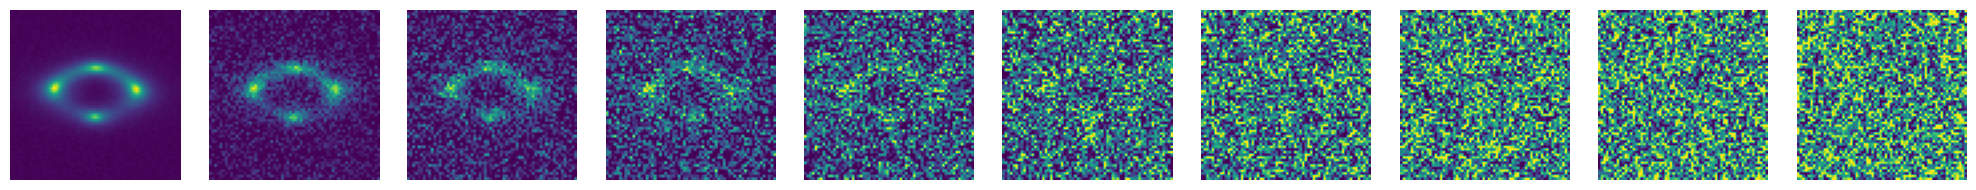

In [34]:
image = next(iter(train_loader))[0]

num_images = 10
# plt.figure(figsize=(15,15))
# plt.axis('off')
stepsize = int(T/num_images)
images_to_plot = []
fig, axs = plt.subplots(1, num_images, figsize=(20, 2))

for i, idx in enumerate(range(0, T, stepsize)):
    t = torch.Tensor([idx]).type(torch.int64)
    image, noise = forward_diffusion_sample(image, t)
    img_display = (image + 1) / 2  # Scale from [-1, 1] back to [0, 1]
    img_display = img_display.clamp(0, 1)
    img_display = img_display.permute(1, 2, 0).cpu().numpy()  
    axs[i].imshow(img_display)
    axs[i].axis('off')  
#     images_to_plot.append(image)
#     show_tensor_image(image)
plt.tight_layout()
plt.show()

In [35]:
noise.shape

torch.Size([1, 64, 64])

In [36]:
from torch.optim import Adam

Epoch 0 | step 000 Loss: 0.815062940120697 


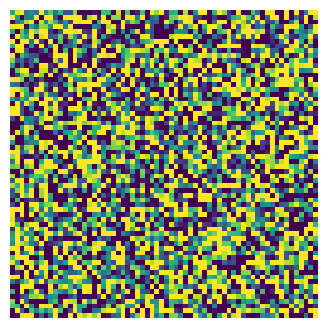

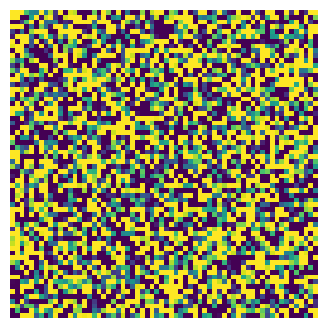

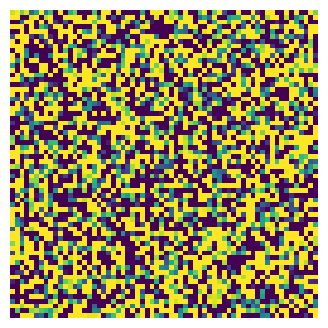

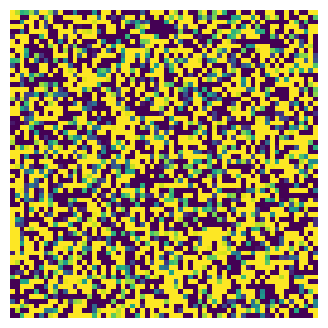

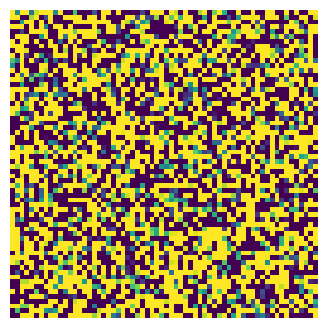

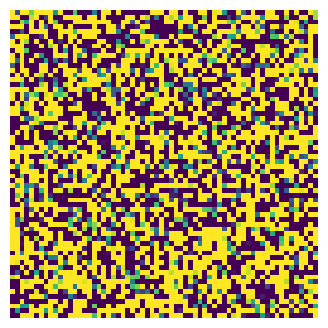

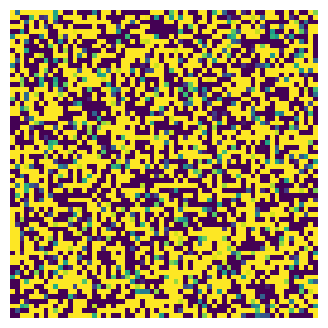

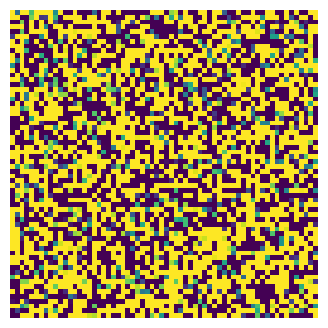

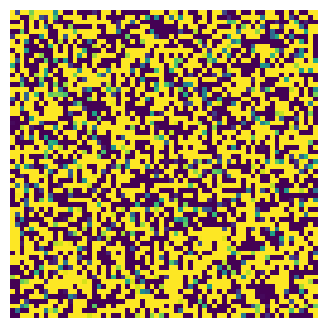

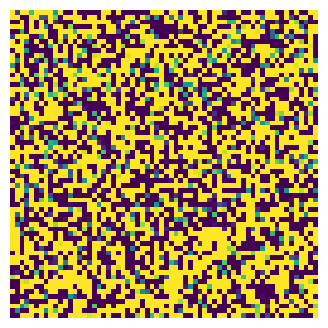

<Figure size 640x480 with 0 Axes>

Epoch 5 | step 000 Loss: 0.12144497781991959 


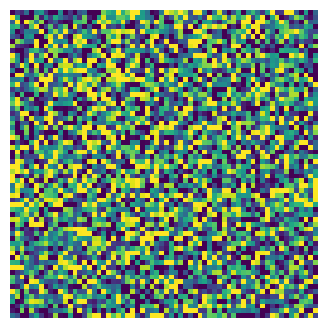

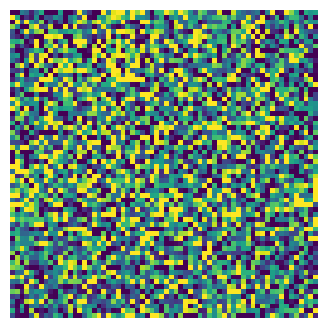

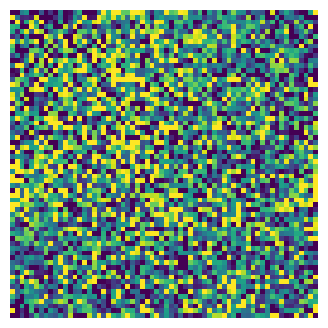

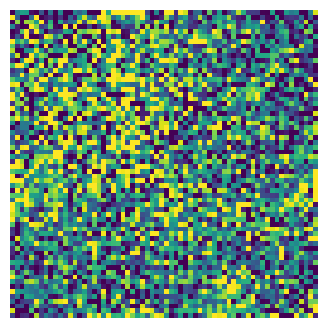

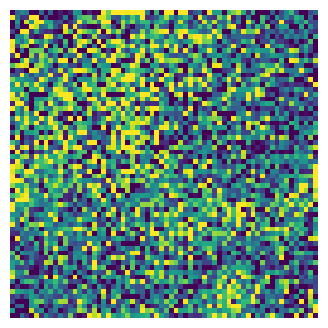

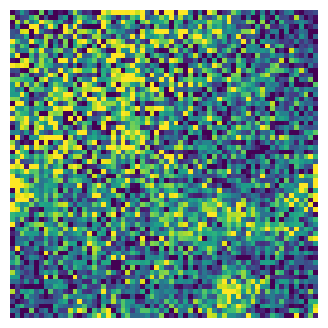

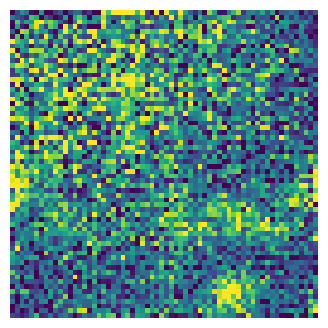

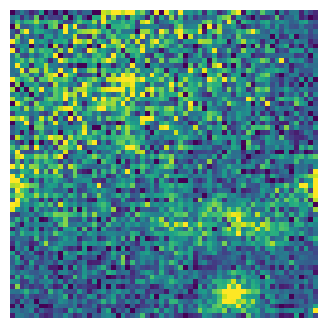

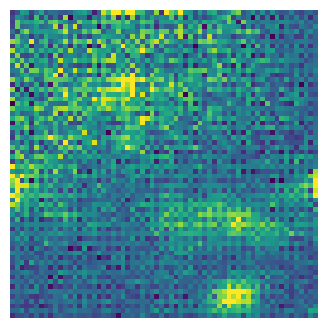

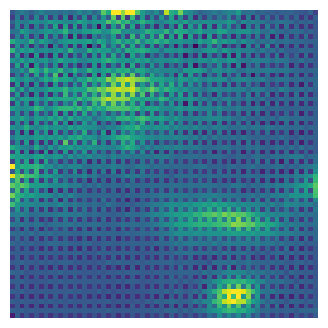

<Figure size 640x480 with 0 Axes>

Epoch 10 | step 000 Loss: 0.09547179937362671 


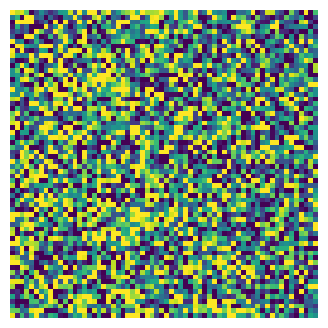

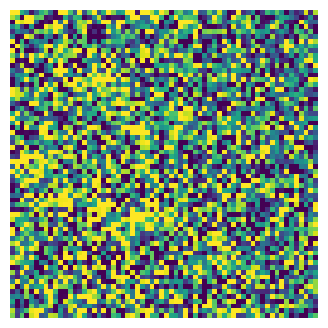

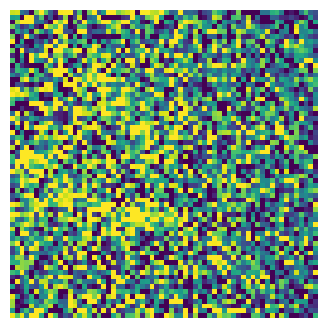

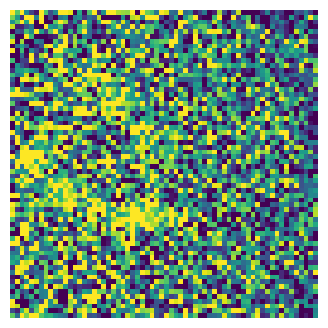

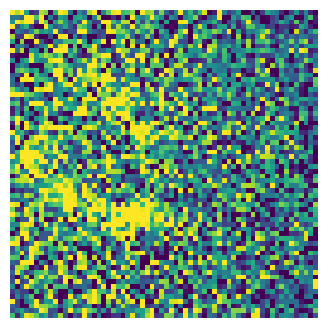

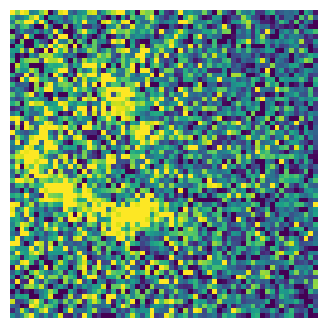

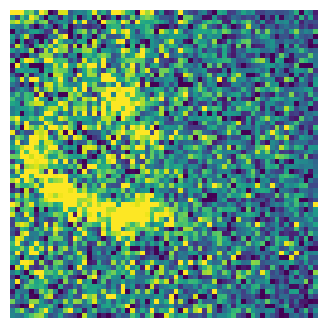

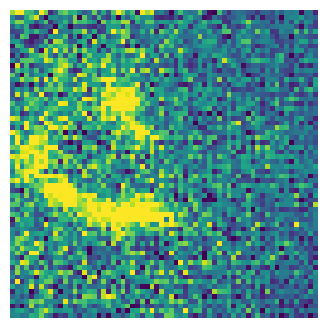

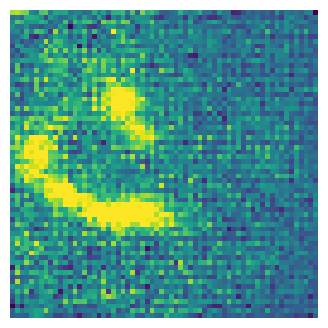

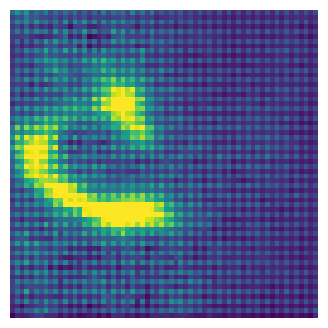

<Figure size 640x480 with 0 Axes>

Epoch 15 | step 000 Loss: 0.09252765774726868 


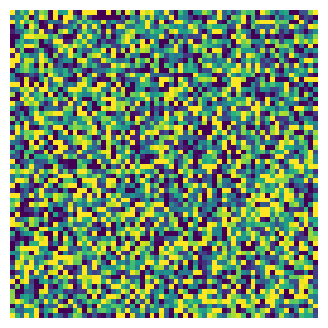

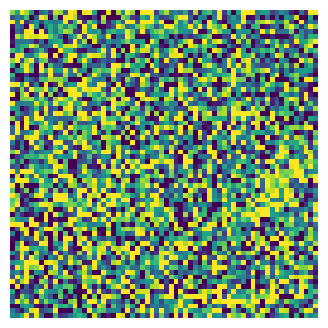

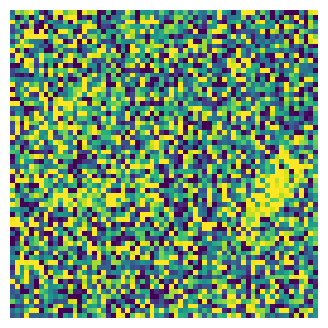

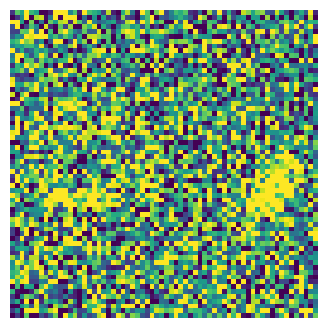

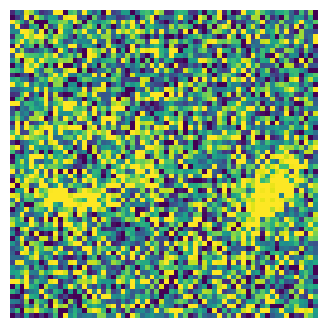

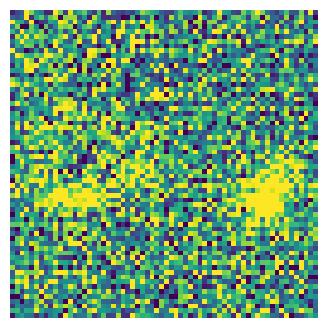

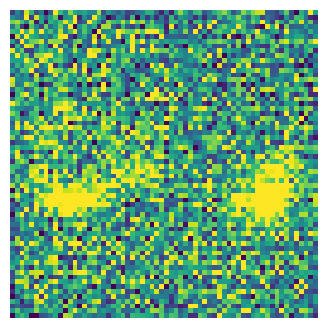

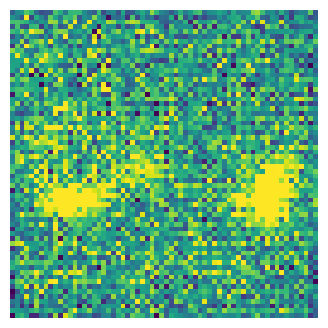

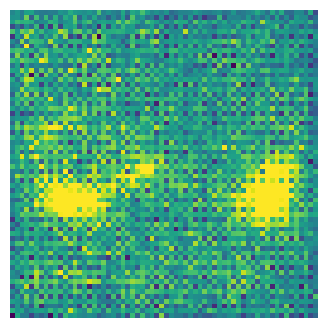

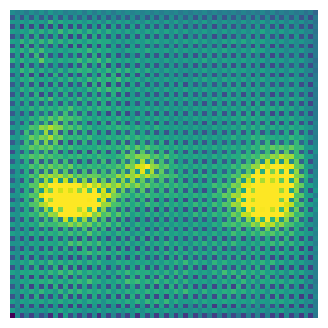

<Figure size 640x480 with 0 Axes>

Epoch 20 | step 000 Loss: 0.06859256327152252 


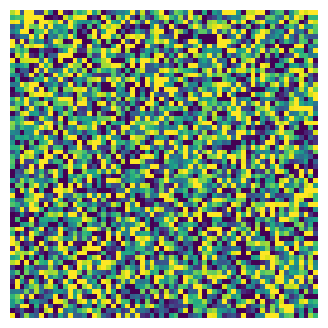

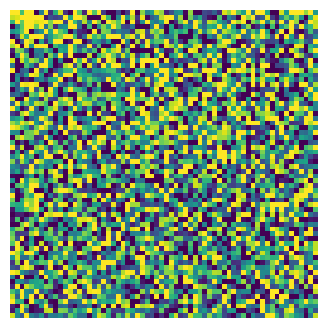

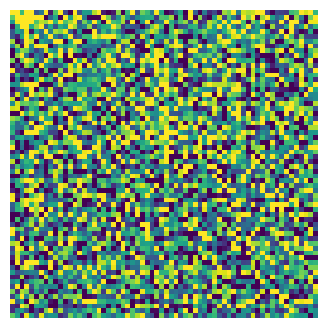

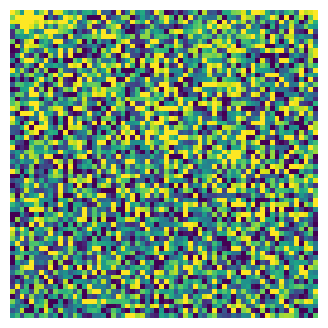

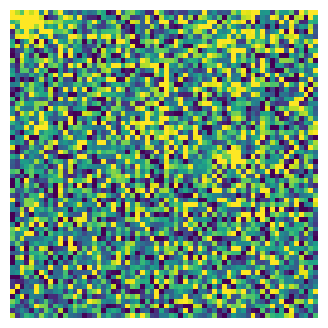

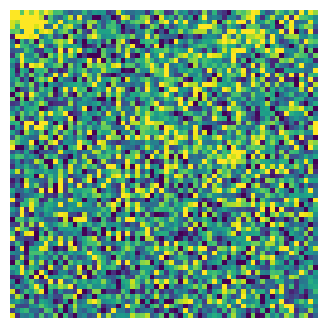

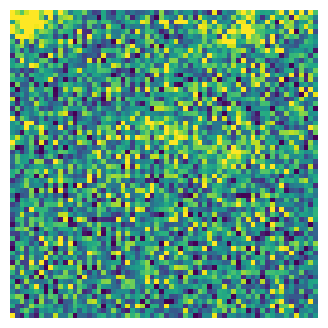

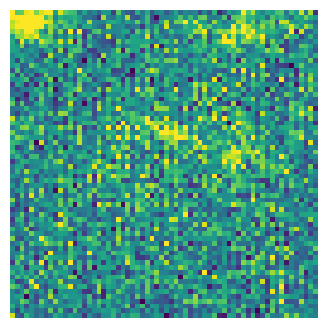

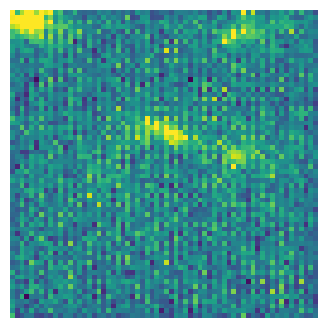

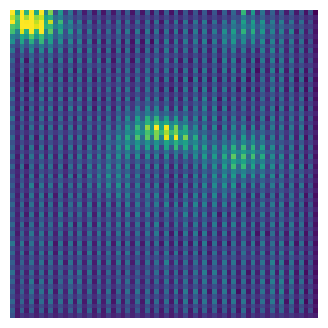

<Figure size 640x480 with 0 Axes>

Epoch 25 | step 000 Loss: 0.06230385601520538 


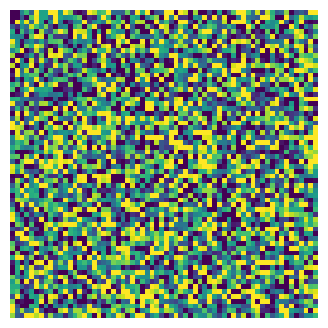

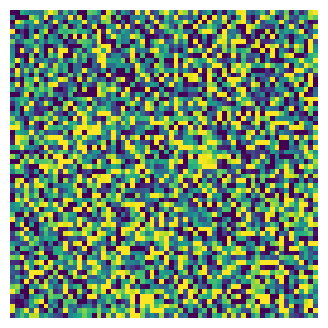

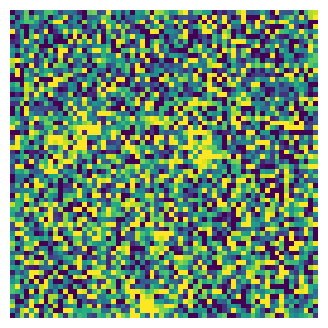

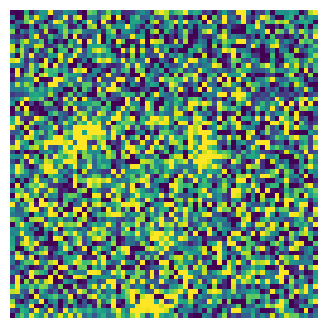

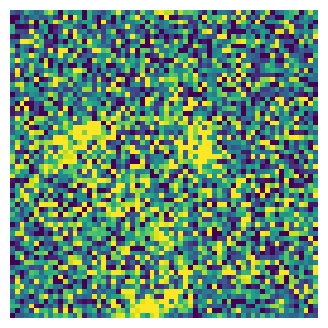

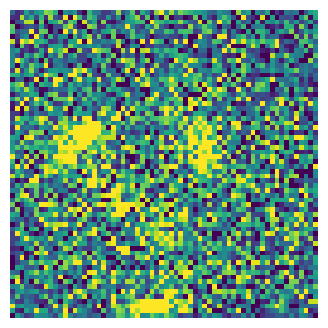

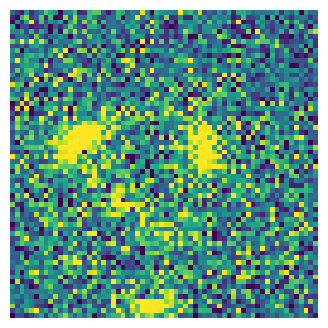

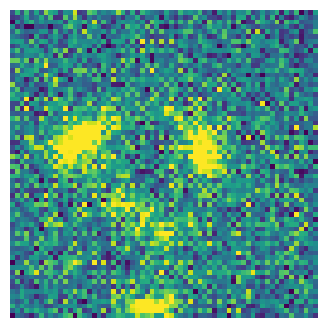

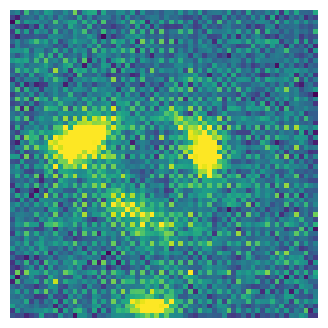

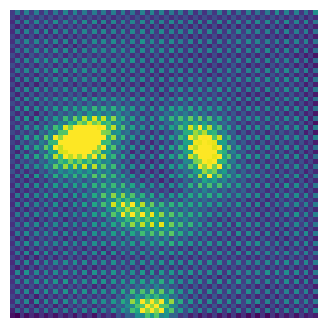

<Figure size 640x480 with 0 Axes>

Epoch 30 | step 000 Loss: 0.06572754681110382 


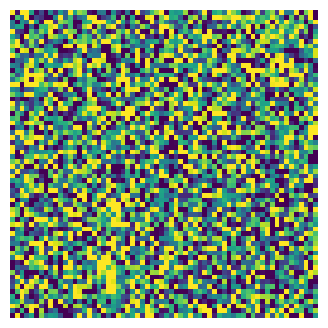

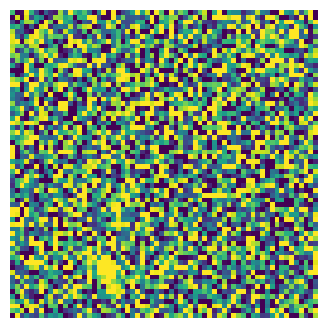

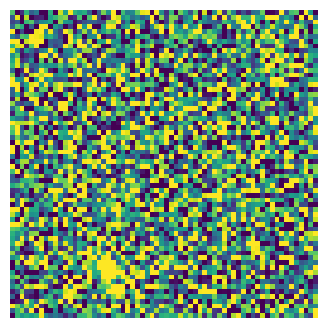

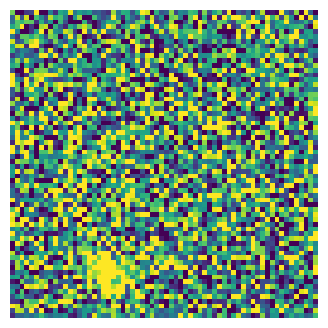

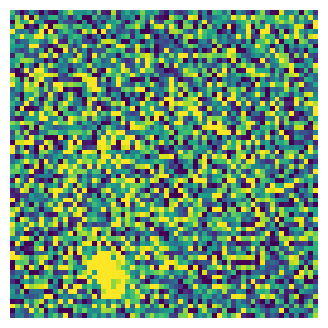

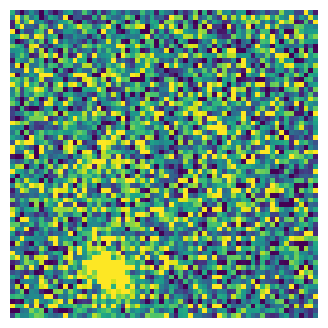

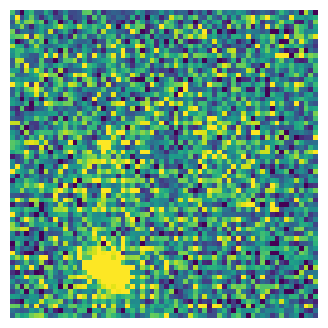

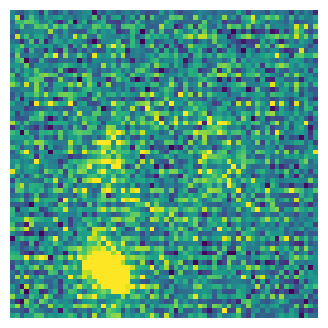

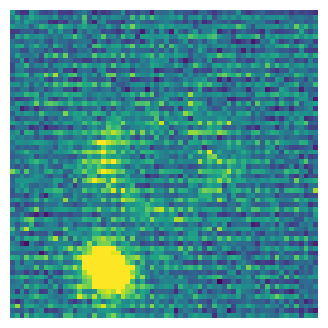

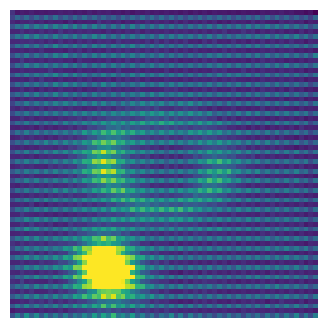

<Figure size 640x480 with 0 Axes>

Epoch 35 | step 000 Loss: 0.058997854590415955 


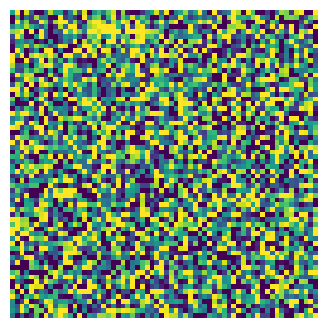

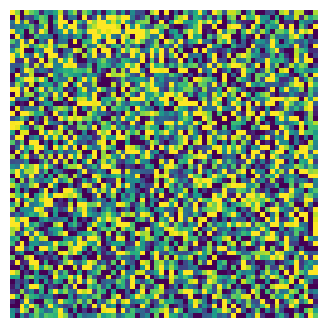

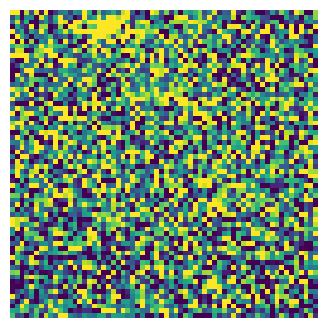

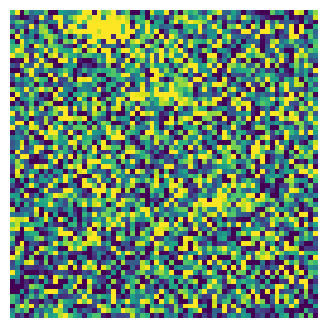

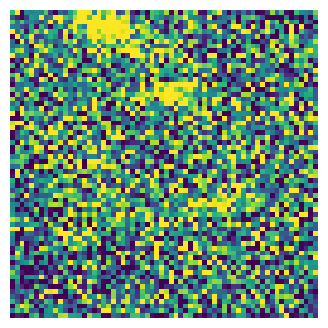

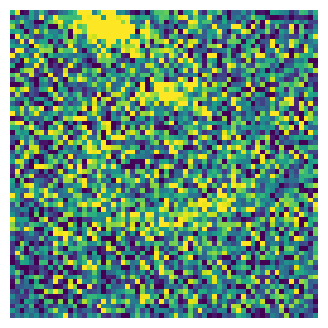

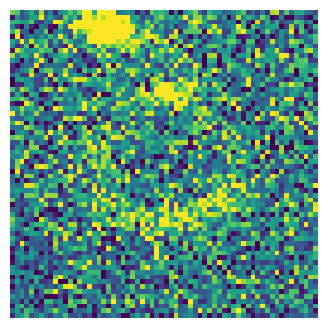

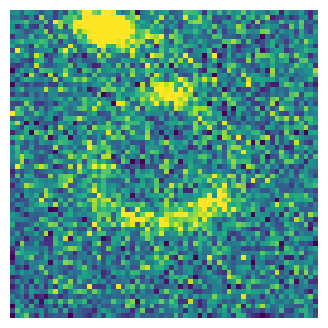

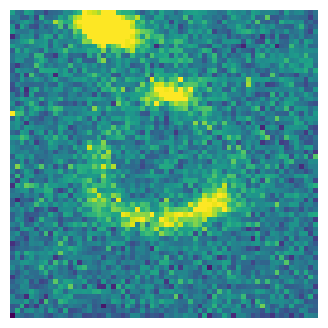

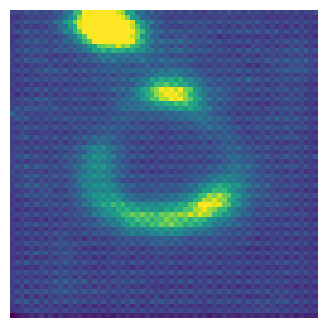

<Figure size 640x480 with 0 Axes>

Epoch 40 | step 000 Loss: 0.058775417506694794 


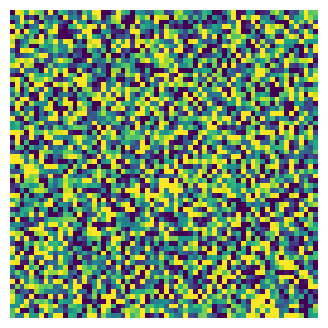

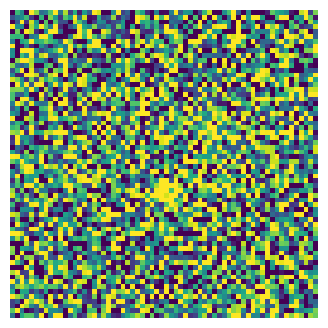

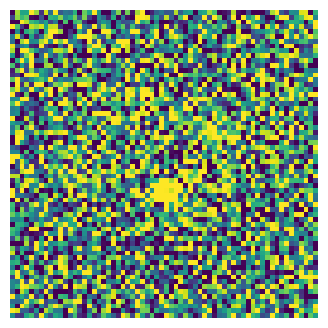

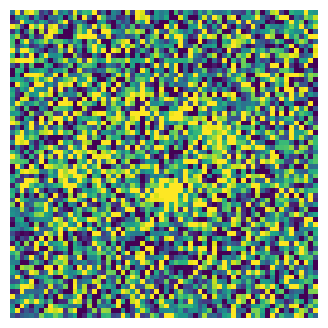

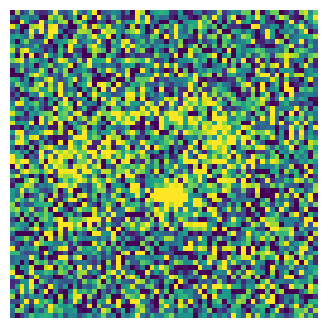

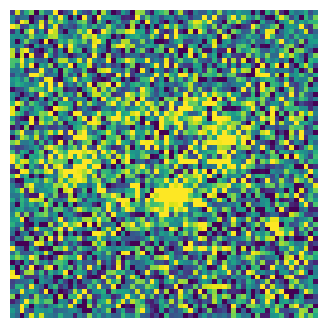

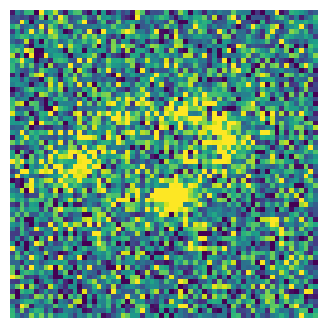

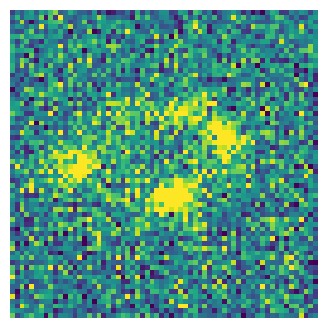

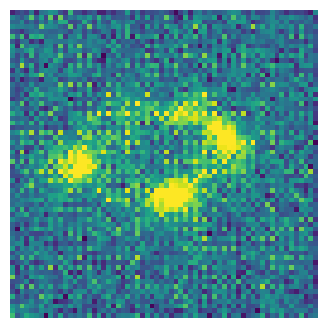

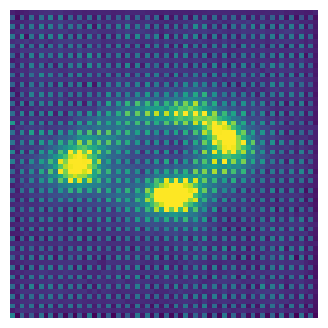

<Figure size 640x480 with 0 Axes>

In [37]:
model.to(device)
optimizer = Adam(model.parameters(), lr=3.5e-4)
epochs = 45

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GrayscaleCNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(GrayscaleCNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        return x


In [98]:
def generate_images(model, dataloader, device):
    model.eval()
    generated_images = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch.to(device)
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
            generated = model(images, t)  
            generated_images.append(generated.cpu())
    generated_images = torch.cat(generated_images, dim=0)
    return generated_images

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = GrayscaleCNNFeatureExtractor().to(device)

# Test with a single batch
sample_images = next(iter(test_loader))
print(sample_images.shape)
sample_images = sample_images.to(device)
sample_features = feature_extractor(sample_images)

torch.Size([128, 1, 64, 64])


In [104]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for data in dataloader:
            images = data.to(device)
            feature = model(images).cpu().numpy()
            features.append(feature)
    features = np.concatenate(features, axis=0)
    return features

feature_extractor = GrayscaleCNNFeatureExtractor().to(device)
# Extract features for real images
real_features = extract_features(feature_extractor, test_loader, device)

# Assuming you have a function to generate a batch of images from your model
generated_images = generate_images(model, test_loader, device)  # Update accordingly
generated_images_loader = DataLoader(generated_images, batch_size=128, shuffle=False)

# Extract features for generated images
generated_features = extract_features(feature_extractor, generated_images_loader, device)

In [105]:
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # Calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # Check and correct complex values from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid_score = calculate_fid(real_features, generated_features)
print(f"FID score: {fid_score}")

FID score: 0.043737338785049276
